In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

df = pd.read_csv("OnlineRetail.csv",encoding='unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [8]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "UnitPrice")

df.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T

,count,mean,std,min,0%,5%,50%,95%,99%,100%,max
Quantity,541909.0,8.519687,154.626855,-80995.00,-80995.00,1.00,3.00,29.00,100.0,253.000,253.000
UnitPrice,541909.0,3.327278,21.652615,-11062.06,-11062.06,0.42,2.08,9.95,18.0,44.715,44.715
CustomerID,406829.0,15287.690570,1713.600303,12346.00,12346.00,12626.00,15152.00,17905.00,18212.0,18287.000,18287.000


In [9]:
df.dropna(axis=0, inplace=True)
df["Description"] = df["Description"].str.strip(" ")
df = df[~df["InvoiceNo"].str.contains("C", na=False)]
df = df[df["StockCode"].apply(lambda x: str(x).isnumeric())]
df = df[df["Quantity"] > 0]

In [10]:
basket = (df[df["Country"] == "Germany"]
              .groupby(["InvoiceNo", "Description"])["Quantity"]
              .sum().unstack().fillna(0)
              .applymap(lambda x: 1 if x > 0 else 0))
basket.iloc[0:5, 0:5]

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND
InvoiceNo,,,,,
536527,0,0,0,0,0
536840,0,0,0,0,0
536861,0,0,0,0,0
536983,0,0,0,0,0
537197,0,0,0,0,0


In [11]:
frequent_itemsets = apriori(basket, min_support=0.02, use_colnames=True)

In [12]:
frequent_itemsets.head()

,support,itemsets
0,0.024943,(10 COLOUR SPACEBOY PEN)
1,0.022676,(12 PENCIL SMALL TUBE WOODLAND)
2,0.020408,(12 PENCILS TALL TUBE WOODLAND)
3,0.034014,(3 HOOK HANGER MAGIC GARDEN)
4,0.043084,(3 PIECE SPACEBOY COOKIE CUTTER SET)


In [13]:
rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.01)

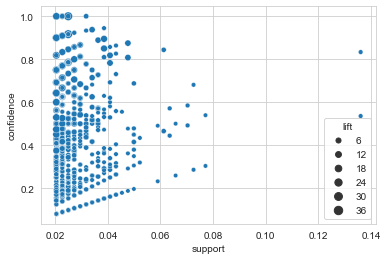

In [15]:
sns.scatterplot(x = "support", y = "confidence",
                size = "lift", data = rules)
plt.show()

In [16]:
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(3 PIECE SPACEBOY COOKIE CUTTER SET),(ROUND SNACK BOXES SET OF4 WOODLAND),0.043084,0.253968,0.022676,0.526316,2.072368,0.011734,1.574956
1,(ROUND SNACK BOXES SET OF4 WOODLAND),(3 PIECE SPACEBOY COOKIE CUTTER SET),0.253968,0.043084,0.022676,0.089286,2.072368,0.011734,1.050731
2,(BLUE HARMONICA IN BOX),(6 RIBBONS RUSTIC CHARM),0.049887,0.106576,0.020408,0.409091,3.838491,0.015091,1.511948
3,(6 RIBBONS RUSTIC CHARM),(BLUE HARMONICA IN BOX),0.106576,0.049887,0.020408,0.191489,3.838491,0.015091,1.175140
4,(CHARLOTTE BAG APPLES DESIGN),(6 RIBBONS RUSTIC CHARM),0.068027,0.106576,0.020408,0.300000,2.814894,0.013158,1.276320
